In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2, os
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
Real_data =  np.load('/content/gdrive/MyDrive/DL_project/Final_Real.npy',allow_pickle=True)

In [4]:
np.shape(Real_data)

(6000, 5)

In [5]:
X_M_test,y_M_test,X_F_test,y_F_test = [],[],[],[]
# sample data [ID,G, fingerNum, img_resize, "Real/Fake"]

for _, gender, _, feature, _ in Real_data:
    if gender == 'M':
        X_M_test.append(feature)
        y_M_test.append(0)
    else:
        X_F_test.append(feature)
        y_F_test.append(1)


In [6]:
X_M_test=X_M_test[0:1230]
y_M_test=y_M_test[0:1230]

In [7]:
x_data, y_data= [], []
x_data=np.concatenate([X_M_test, X_F_test], axis=0)
y_data=np.concatenate([y_M_test, y_F_test], axis=0)

del X_M_test,X_F_test,y_M_test,y_F_test

In [8]:
img_size = 96
x_data = np.array(x_data).reshape(-1, img_size, img_size,1)
x_data = x_data / 255.0

In [9]:
y_data = to_categorical(y_data, num_classes=2)

In [10]:
len(x_data)

2460

In [11]:
X_train, X_Gender_test, y_train, y_Gender_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=2)

In [12]:
X_Gender_train, X_Gender_val, y_Gender_train, y_Gender_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2)

In [13]:
print("Shapes:              Feature shape    label shape")
print("----------------------------------------------------")
print("Gender_Train:      ", np.shape(X_Gender_train), np.shape(y_Gender_train))
print("Gender_Validation: ", np.shape(X_Gender_val), np.shape(y_Gender_val))
print("Gender_Test:       ", np.shape(X_Gender_test), np.shape(y_Gender_test))
print("----------------------------------------------------")
print("Total Data:        ", np.shape(x_data), np.shape(y_data))

#del Altered_data, Real_data,X_Altered, y_Gender_Altered # Free some memory again

Shapes:              Feature shape    label shape
----------------------------------------------------
Gender_Train:       (1574, 96, 96, 1) (1574, 2)
Gender_Validation:  (394, 96, 96, 1) (394, 2)
Gender_Test:        (492, 96, 96, 1) (492, 2)
----------------------------------------------------
Total Data:         (2460, 96, 96, 1) (2460, 2)


In [14]:
nets = 1
model = [0] * nets
final_Dense_units = [2]
model_name = ['Gender_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96,1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "Gender_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 64)       256       
 hNormalization)                                                 
                                                        

In [15]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 30
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_Gender_train, y_Gender_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_Gender_val, y_Gender_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/30
25/25 [==============================] - 13s 118ms/step - loss: 1.1571 - accuracy: 0.5451 - val_loss: 0.8301 - val_accuracy: 0.4772 - lr: 1.0000e-04
Epoch 2/30
24/25 [===========================>..] - ETA: 0s - loss: 0.7896 - accuracy: 0.6712
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
25/25 [==============================] - 2s 69ms/step - loss: 0.7914 - accuracy: 0.6728 - val_loss: 0.8308 - val_accuracy: 0.4670 - lr: 1.0000e-04
Epoch 3/30
24/25 [===========================>..] - ETA: 0s - loss: 0.7246 - accuracy: 0.6914
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
25/25 [==============================] - 2s 69ms/step - loss: 0.7251 - accuracy: 0.6906 - val_loss: 0.8446 - val_accuracy: 0.4569 - lr: 1.0000e-05
Epoch 4/30
24/25 [===========================>..] - ETA: 0s - loss: 0.7241 - accuracy: 0.7012
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
25/25 [=============================

Id recognition accuracy:  99.83333349227905 %


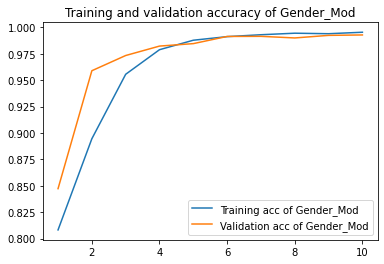

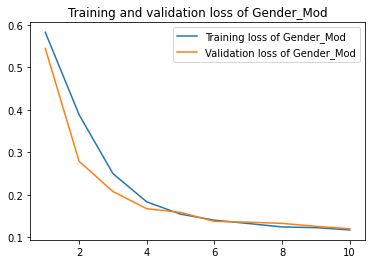

In [ ]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_Gender_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
#testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
#print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

In [16]:
test_loss,test_acc = model[0].evaluate(X_Gender_test, y_Gender_test)

16/16 [==============================] - 1s 21ms/step - loss: 0.7656 - accuracy: 0.6545


In [17]:
#accuracy_score
print("The testing accuracy of the model - " + str(round(test_acc*100,2)) + "%")

The testing accuracy of the model - 65.45%


In [18]:
y_Gender_pred = model[0].predict(X_Gender_test)

In [19]:
np.shape(y_Gender_pred)

(492, 2)

In [20]:
np.shape(y_Gender_test)

(492, 2)

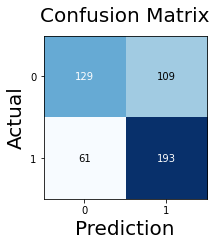

In [23]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

labels= ['Male', 'Female']
cf = confusion_matrix(y_Gender_test.argmax(axis = 1), y_Gender_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf, figsize=(6, 3), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
print(classification_report(y_Gender_test.argmax(axis = 1),y_Gender_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.68      0.54      0.60       238
           1       0.64      0.76      0.69       254

    accuracy                           0.65       492
   macro avg       0.66      0.65      0.65       492
weighted avg       0.66      0.65      0.65       492



Mobilenet

In [25]:
import cv2 as cv
samples  = X_Gender_train.shape[0]
X_MF_train = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(X_Gender_train[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_MF_train[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [26]:
import cv2 as cv
samples  = X_Gender_val.shape[0]
X_MF_val = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(X_Gender_val[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_MF_val[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [27]:
import cv2 as cv
#(X_Gender_test, y_Gender_test
samples  = X_Gender_test.shape[0]
X_MF_test = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(X_Gender_test[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_MF_test[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [39]:
from tensorflow.keras.applications import MobileNet
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(512,activation='relu')(x) #dense layer 2
x=Dense(256,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [40]:
MobileNet_model=Model(inputs=base_model.input,outputs=preds)

In [42]:
CallBack = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
    callbacks.TensorBoard(log_dir="./log_dir/"+"MobileNet_model")]


In [43]:
MobileNet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = MobileNet_model.fit(X_MF_train, y_Gender_train, batch_size = 64, epochs = 20, validation_data = (X_MF_val, y_Gender_val),callbacks= CallBack[0])

Epoch 1/20
25/25 [==============================] - 8s 201ms/step - loss: 0.0968 - accuracy: 0.9676 - val_loss: 2.7626 - val_accuracy: 0.6320
Epoch 2/20
25/25 [==============================] - 4s 176ms/step - loss: 0.0899 - accuracy: 0.9619 - val_loss: 3.6785 - val_accuracy: 0.6168
Epoch 3/20
25/25 [==============================] - 4s 176ms/step - loss: 0.1370 - accuracy: 0.9638 - val_loss: 3.7244 - val_accuracy: 0.6371
Epoch 4/20
25/25 [==============================] - 4s 175ms/step - loss: 0.0979 - accuracy: 0.9714 - val_loss: 3.1891 - val_accuracy: 0.6777
Epoch 5/20
25/25 [==============================] - 4s 176ms/step - loss: 0.0815 - accuracy: 0.9701 - val_loss: 9.5033 - val_accuracy: 0.6269
Epoch 6/20
25/25 [==============================] - 4s 177ms/step - loss: 0.0551 - accuracy: 0.9803 - val_loss: 5.5303 - val_accuracy: 0.6371
Epoch 7/20
25/25 [==============================] - 4s 175ms/step - loss: 0.0603 - accuracy: 0.9822 - val_loss: 5.5670 - val_accuracy: 0.6396
Epoch 

In [44]:
test_loss,test_acc = MobileNet_model.evaluate(X_MF_test, y_Gender_test)

16/16 [==============================] - 0s 25ms/step - loss: 3.2350 - accuracy: 0.6077


In [45]:
y_MF_pred = MobileNet_model.predict(X_MF_test)

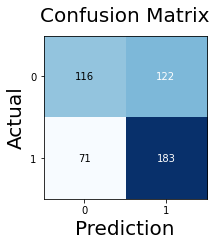

In [46]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

labels= ['Male', 'Female']
cf = confusion_matrix(y_Gender_test.argmax(axis = 1), y_MF_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf, figsize=(6, 3), cmap=plt.cm.Blues)
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
print(classification_report(y_Gender_test.argmax(axis = 1),y_MF_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.62      0.49      0.55       238
           1       0.60      0.72      0.65       254

    accuracy                           0.61       492
   macro avg       0.61      0.60      0.60       492
weighted avg       0.61      0.61      0.60       492

